In [2]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf


In [3]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [4]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras


train = pd.read_csv("data/train.csv") 
test  = pd.read_csv("data/test.csv")  

train['file_name'] = train['file_name'].apply(lambda x: os.path.join('data', x))
if 'file_name' in test.columns:
    test['file_name'] = test['file_name'].apply(lambda x: os.path.join('data', x))
else:
    # test CSV has column 'id' instead
    test['file_name'] = test['id'].apply(lambda x: os.path.join('data', 'test_data_v2', x))


train_df, val_df = train_test_split(
    train, 
    test_size=0.2, 
    random_state=42, 
    stratify=train['label']
)

def create_generators(train_df, val_df, test_df):
    train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.1,
    horizontal_flip=True
    )
    test_val_datagen = ImageDataGenerator(rescale=1./255)

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='file_name',
        y_col='label',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32,
        shuffle=True
    )
    val_generator = test_val_datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='file_name',
        y_col='label',
        target_size=(224, 224),
        class_mode='raw',
        batch_size=32,
        shuffle=False
    )
    test_generator = test_val_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='file_name',
        y_col=None,
        target_size=(224, 224),
        class_mode=None,
        batch_size=32,
        shuffle=False
    )

    return train_generator, val_generator, test_generator

train_gen, val_gen, test_gen = create_generators(train_df, val_df, test)

Found 63960 validated image filenames.
Found 15990 validated image filenames.
Found 0 validated image filenames.


/Users/parisbozzuti/Desktop/362final_backup/.venv/lib/python3.11/site-packages/keras/src/legacy/preprocessing/image.py:918: UserWarning: Found 5540 invalid image filename(s) in x_col="file_name". These filename(s) will be ignored.
  warnings.warn(


In [5]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
base_model.trainable = True 

for layer in base_model.layers[:-40]:  
    layer.trainable = False

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)


history = model.fit(
    train_gen,
    epochs=10,
    validation_data=val_gen,
    verbose=1
)

2025-12-07 16:49:35.299668: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2025-12-07 16:49:35.299702: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-12-07 16:49:35.299709: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-12-07 16:49:35.299956: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-12-07 16:49:35.300006: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2025-12-07 16:49:37.930054: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1999/1999 ━━━━━━━━━━━━━━━━━━━━ 420s 207ms/step - accuracy: 0.8338 - loss: 0.4015 - val_accuracy: 0.9230 - val_loss: 0.2217
Epoch 2/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 379s 189ms/step - accuracy: 0.9248 - loss: 0.2115 - val_accuracy: 0.9555 - val_loss: 0.1405
Epoch 3/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 379s 189ms/step - accuracy: 0.9424 - loss: 0.1705 - val_accuracy: 0.9617 - val_loss: 0.1214
Epoch 4/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 378s 189ms/step - accuracy: 0.9535 - loss: 0.1442 - val_accuracy: 0.9568 - val_loss: 0.1380
Epoch 5/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 373s 187ms/step - accuracy: 0.9606 - loss: 0.1236 - val_accuracy: 0.9670 - val_loss: 0.1095
Epoch 6/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 375s 188ms/step - accuracy: 0.9649 - loss: 0.1141 - val_accuracy: 0.9725 - val_loss: 0.0961
Epoch 7/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 377s 189ms/step - accuracy: 0.9682 - loss: 0.1033 - val_accuracy: 0.9688 - val_loss: 0.1077
Epoch 8/10
1999/1999 ━━━━━━━━━━━━━━━━━━━━ 375s 188ms/step - accuracy: 0.9

In [6]:
val_loss, val_acc = model.evaluate(val_gen, verbose=0)
print('Initial validation loss', val_loss)
print('Initial validation accuracy', val_acc)



Initial validation loss 0.09863252192735672
Initial validation accuracy 0.9726078510284424


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


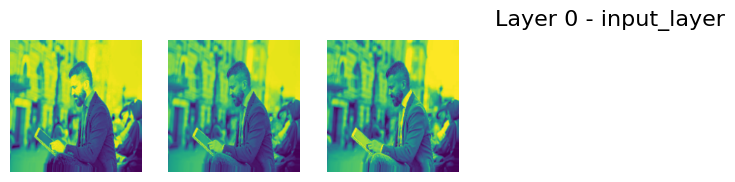

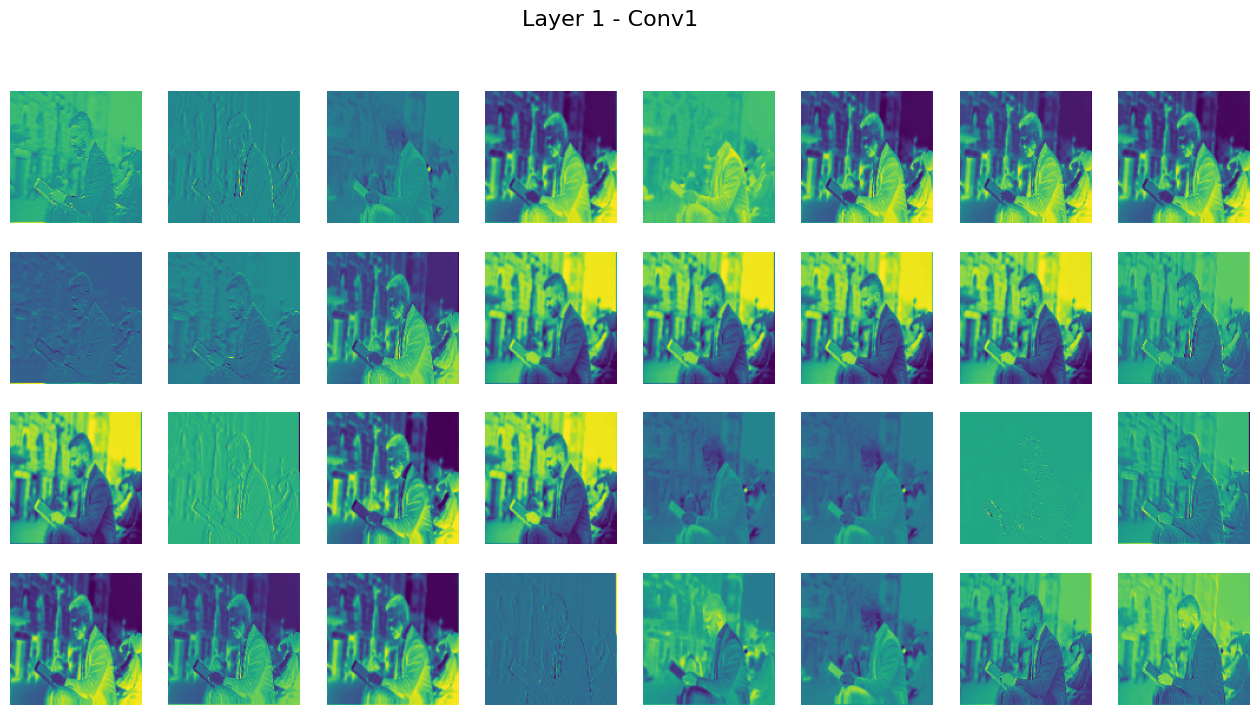

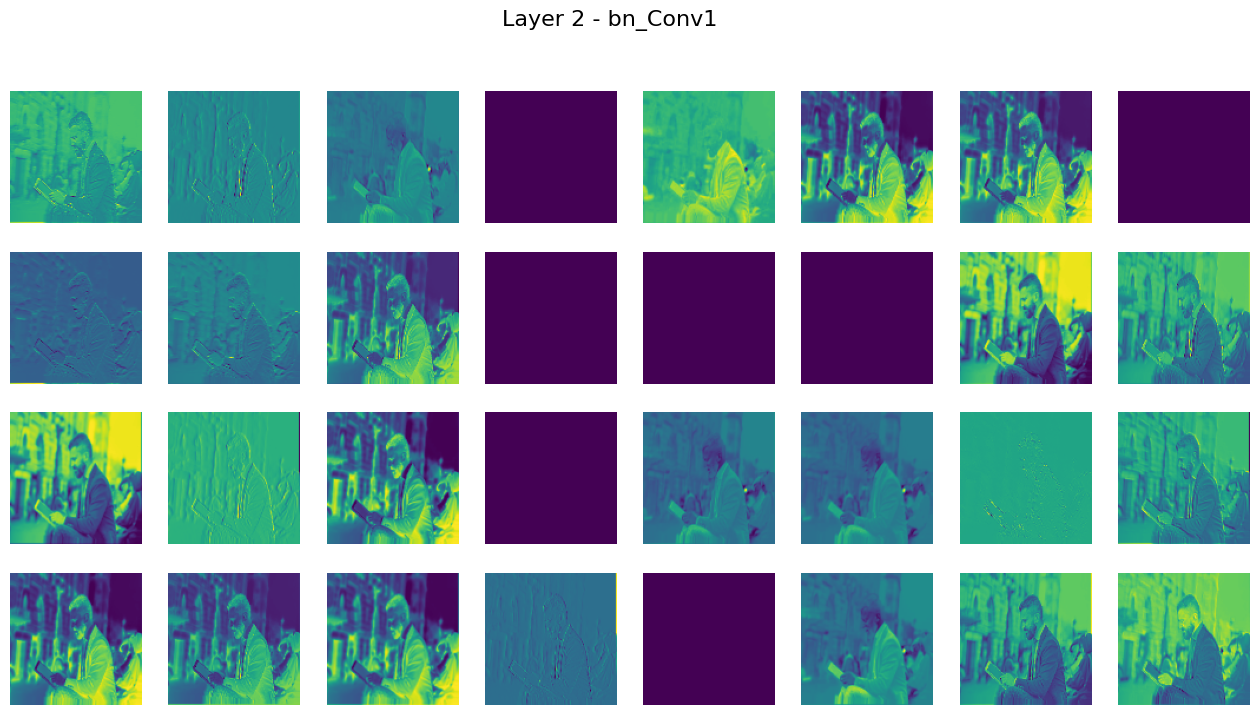

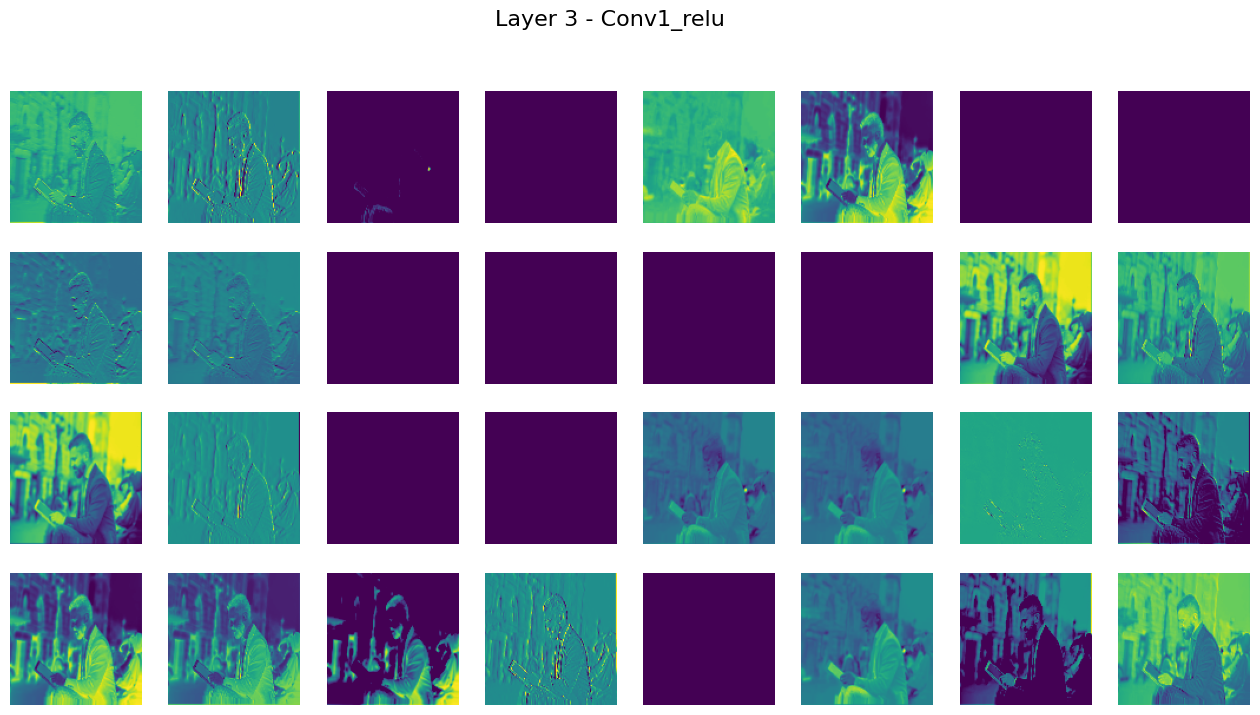

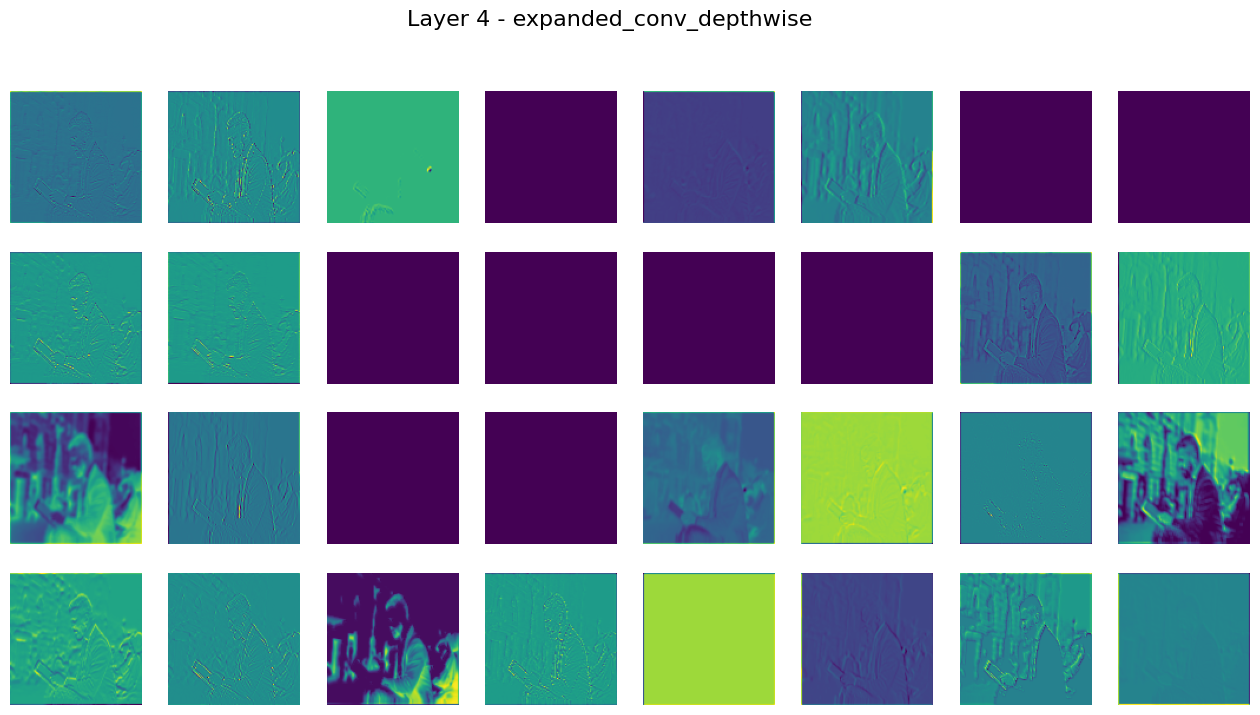

In [22]:
from tensorflow.keras.models import Model
import math
import matplotlib.pyplot as plt

sample_img, _ = next(train_gen) 
img = sample_img[0:1]

base = model.layers[0]

num_layers_to_inspect = 5
layer_outputs = [base.get_layer(base.layers[i].name).output for i in range(num_layers_to_inspect)]

activation_model = Model(inputs=base.input, outputs=layer_outputs)

activations = activation_model.predict(img)

for layer_idx, layer_activation in enumerate(activations):
    num_features = layer_activation.shape[-1]  
    size = layer_activation.shape[1]  

    cols = 8
    rows = math.ceil(num_features / cols)

    plt.figure(figsize=(cols*2, rows*2))
    for i in range(num_features):
        plt.subplot(rows, cols, i+1)
        plt.imshow(layer_activation[0, :, :, i], cmap='viridis')
        plt.axis('off')
    plt.suptitle(f'Layer {layer_idx} - {base.layers[layer_idx].name}', fontsize=16)
    plt.show()
